References:

Lab 4 of IBM Quantum Challenge

https://qiskit-community.github.io/qiskit-machine-learning/ (source code of SamplerQNN etc.)

In [54]:
import torch
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms

import cv2

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
import qiskit_algorithms
from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer import Aer, AerSimulator
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
)
from qiskit.primitives import StatevectorSampler

# Set seed for random generators
algorithm_globals.random_seed = 42

In [39]:
#Training Dataset
# Set train shuffle seed (for reproducibility) Samples here --------------------------------------------------------------------------------
manual_seed(42)
num_classes = 2
training_samples = 50
test_samples = 20

# Use pre-defined torchvision function to load MNIST train data
full_training_data = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.Resize((4, 4)),
                                                                            transforms.ToTensor()])
)

subset = []
for i in range(num_classes):
    idx = np.where(full_training_data.targets == i)[0][:training_samples]
    subset.extend(idx)

train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.Resize((4, 4)),
                                                                             transforms.ToTensor()])
)

train.data = full_training_data.data[subset]
train.targets = full_training_data.targets[subset]

#Split training dataset into training and validation (80%-20%)
# train_size = int(0.8 * len(full_training_data))
# valid_size = len(full_training_data) - train_size

# train, valid = random_split(full_training_data, [train_size, valid_size])

test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.Resize((4, 4)),
                                                                             transforms.ToTensor()])
)

subset = []
for i in range(num_classes):
    idx = np.where(full_training_data.targets == i)[0][:test_samples]
    subset.extend(idx)
    
test.data = full_training_data.data[subset]
test.targets = full_training_data.targets[subset]

print("Train subset size:", len(train))
# print("Valid subset size:", len(valid))
print("Test subset size:", len(test))

def count(dataset):
    counter = {}
    features = []
    labels = []
    for i in range(len(dataset)):
        im, class_idx = dataset[i]
        features.append(np.reshape(im, -1))
        one_hot = np.eye(num_classes)[class_idx]
        labels.append(one_hot)
        if class_idx not in counter:
            counter[class_idx] = 0
        counter[class_idx] += 1
    counter = dict(sorted(counter.items(), key=lambda x: x[0]))

    for key, value in counter.items():
        print(key, ":", value)
    return np.array(features), np.array(labels)
        
print("Training Dataset")
train_feats, train_labels = count(train)

indices = np.arange(train_feats.shape[0])
np.random.shuffle(indices)
train_feats = train_feats[indices]
train_labels = train_labels[indices]

print(train_feats.shape)
print(train_labels.shape)

# print("Validation Dataset")
# count(valid)

print("Testing Dataset")
test_feats, test_labels = count(test)
print(test_feats.shape)
print(test_labels.shape)

Train subset size: 100
Test subset size: 40
Training Dataset
0 : 50
1 : 50
(100, 16)
(100, 2)
Testing Dataset
0 : 20
1 : 20
(40, 16)
(40, 2)


The training dataset has 100 images
After the shuffle the 0th image has class index 1
Image shape is (4, 4, 1)


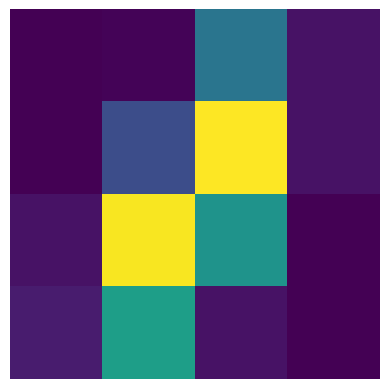

1
After the shuffle the 0th image has class index 0
Image shape is (4, 4, 1)


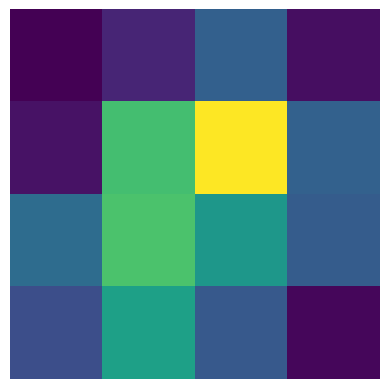

0


In [40]:
'''
Explore the constructed dataset
'''
import random
import matplotlib.pyplot as plt

# Find and output the number of images
n = len(train)
print(f'The training dataset has {n} images')

for i in range(2):
# Randomly shuffle the image indices
    indices = list(range(n))
    random.shuffle(indices)

    # Get the image and the class id of the 0th image after the shuffle.
    im, class_idx = train[indices[0]]
    
    print(f'After the shuffle the 0th image has class index {class_idx}')

    # Convert the image from an array back to a numpy 3d array
    im_np = im.numpy().transpose((1, 2, 0))
    print(f'Image shape is {im_np.shape}')
    # print(im_np)
    # Before displaying the image rescale the intensities to be between 0 and 1
    # im_min = im_np.min()
    # im_max = im_np.max()
    # im_np = (im_np - im_min) / (im_max - im_min)
    # im_np[im_np > 0.5] = 1
    # im_np[im_np < 0.5] = 0

    # Display the image
    plt.imshow(im_np[:,:,::-1])
    plt.axis('off')
    plt.show()
    print(class_idx)

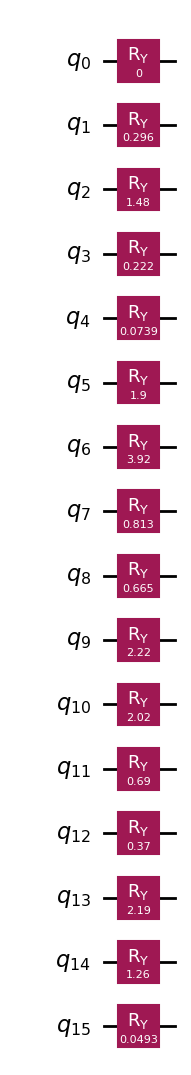

In [42]:
def create_angle_encoding_circuit(image):
    num_qubits = image.size
    qc = QuantumCircuit(num_qubits)
    
    # Flatten the image and encode each pixel using a rotation around the Y-axis
    for i, pixel_value in enumerate(image):
        qc.ry(2 * np.pi * pixel_value, i)
    
    return qc

qc = create_angle_encoding_circuit(train_feats[0])
qc.draw('mpl')

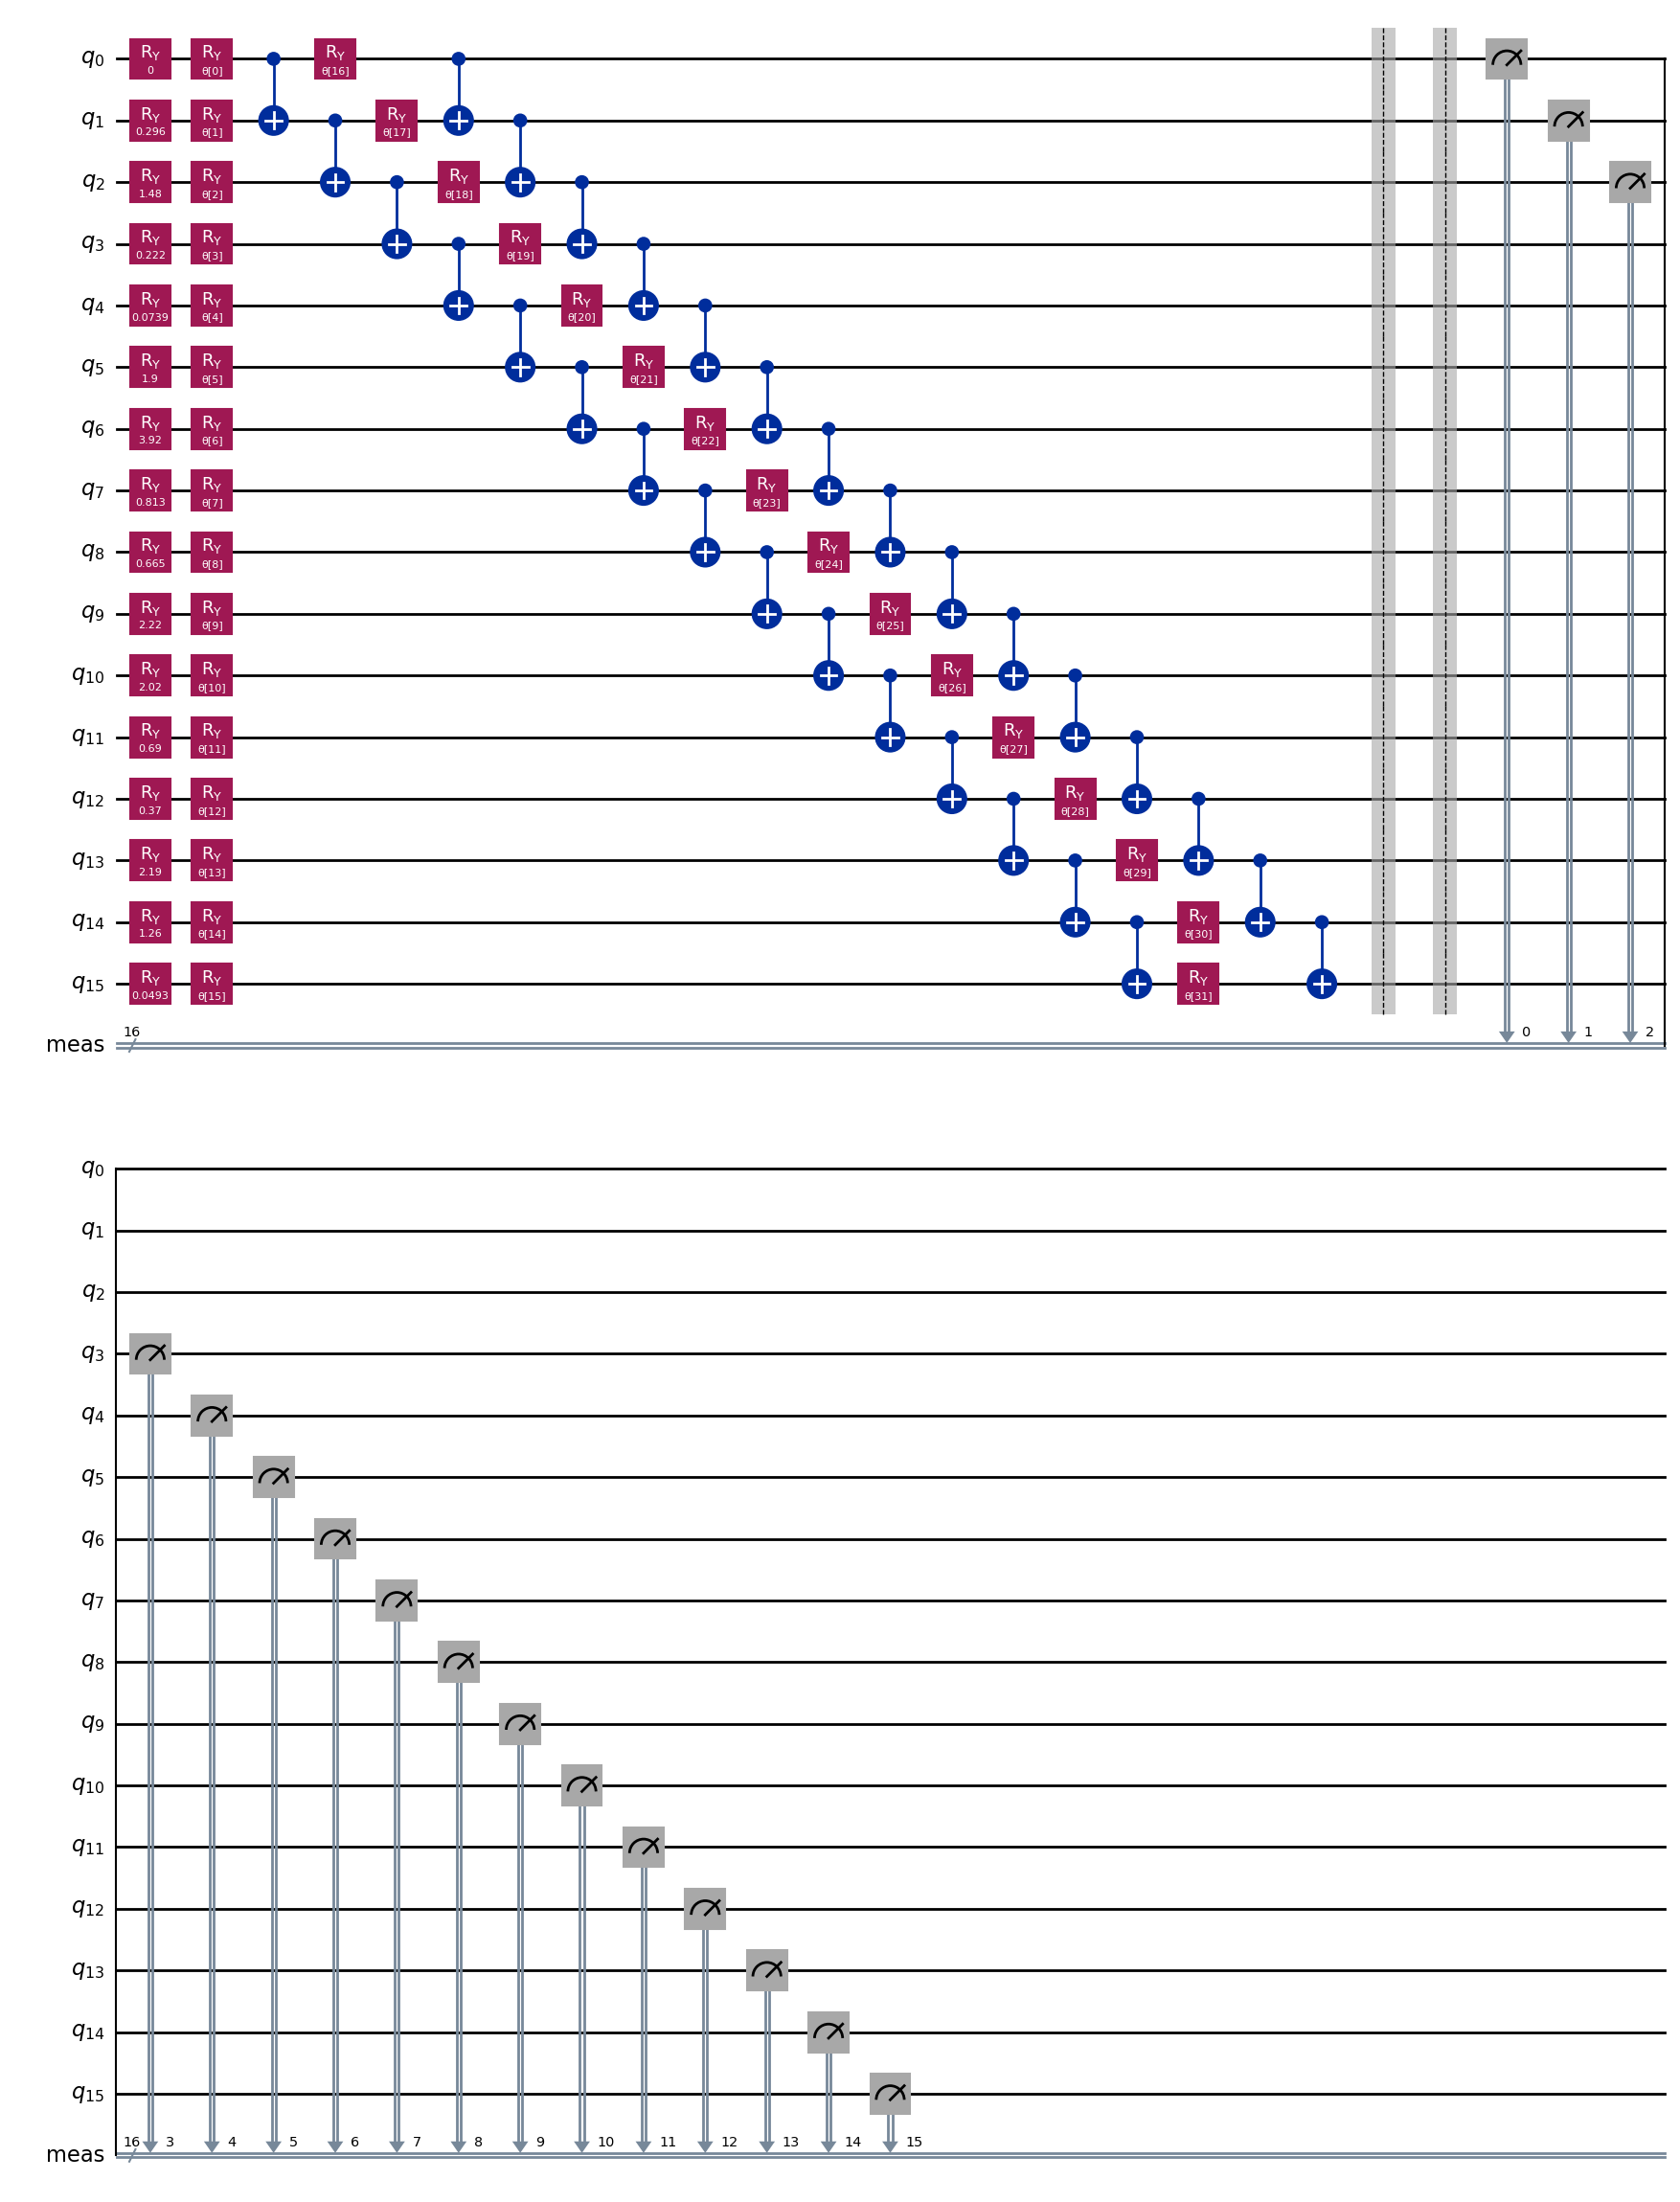

In [43]:
from qiskit.circuit import Parameter, ParameterVector

def create_vqc_circuit(image, num_layers, num_classes):
    num_qubits = image.size
    qc = create_angle_encoding_circuit(image)
    
    # Define a parameter vector for the variational circuit
    params = ParameterVector('θ', length=num_qubits * num_layers)
    
    # Add variational layers
    for layer in range(num_layers):
        for i in range(num_qubits):
            qc.ry(params[i + layer * num_qubits], i)  # Add a parameterized Ry rotation
        for i in range(num_qubits - 1):
            qc.cx(i, i + 1)  # Add entangling gates
    
    qc.barrier()
        
    qc.measure_all()
    
    return qc, params

# Example usage
image = train_feats[0]
num_layers = 2
vqc, params = create_vqc_circuit(image, num_layers, num_classes)
vqc.draw('mpl')

In [71]:
qc, param_vector = create_vqc_circuit(train_feats[0], num_layers, num_classes)
params = np.random.rand(num_qubits * num_layers)
param_dict = {param_vector[i]: params[i] for i in range(len(params))}
qc = qc.assign_parameters(param_dict)

# Execute the circuit
simulator = AerSimulator()
pm = generate_preset_pass_manager(backend=simulator, optimization_level=3)
isa_circuit = pm.run(qc)
sampler = StatevectorSampler()
result = sampler.run([isa_circuit]).result()
counts = result[0].data.meas.get_counts()

class_probs = np.zeros(num_classes)
for bit_string, count in counts.items():
    class_index = int(bit_string, 2) % num_classes
    class_probs[class_index] += count
print(class_probs)
one_hot = np.eye(num_classes)[np.argmax(class_probs)]
print(one_hot)
print(type(one_hot))
print(type(train_labels))

[528. 496.]
[1. 0.]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [72]:
import time
from scipy.optimize import minimize
from sklearn.metrics import log_loss

# Essentially cross entropy loss
def cost_function(params, X, y, num_layers, num_classes):
    global iteration
    loss = 0
    predictions = []
    start_iter = time.time()
    for image, label in zip(X, y):
        qc, param_vector = create_vqc_circuit(image, num_layers, num_classes)
        param_dict = {param_vector[i]: params[i] for i in range(len(params))}
        qc = qc.assign_parameters(param_dict)
        
        # Execute the circuit
        simulator = AerSimulator()
        pm = generate_preset_pass_manager(backend=simulator, optimization_level=3)
        isa_circuit = pm.run(qc)
        sampler = StatevectorSampler()
        #sampler = Sampler(backend=backend)
        result = sampler.run([isa_circuit]).result()
        counts = result[0].data.meas.get_counts()
        
        # Calculate probabilities for each class
        class_probs = np.zeros(num_classes)
        for bit_string, count in counts.items():
            class_index = int(bit_string, 2) % num_classes
            class_probs[class_index] += count

        one_hot = np.eye(num_classes)[np.argmax(class_probs)]
        
        predictions.append(one_hot.tolist())

    # Compute the cross-entropy loss
    loss += log_loss(y, predictions)
    elapsed_iter = time.time() - start
    print(f"Iteration {iteration}: Loss: {loss}\nTime Elapsed: {round(elapsed_iter)} seconds\n")
    iteration+=1
    
    return loss
    
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

best_loss = float('inf')
best_params = None
# Minimize the cost function
for _ in range(5):
# Set initial parameters
    initial_params = np.random.rand(num_qubits * num_layers)
    iteration = 0
    start = time.time()
    result = minimize(cost_function, initial_params, args=(train_feats, train_labels, num_layers, num_classes), method="cobyla", options={'maxiter': 10})
    elapsed = time.time() - start
    if result.fun < best_loss:
        best_loss = result.fun
        best_params = result.x
print(f"Training time: {round(elapsed)} seconds")
optimized_params = best_params

Iteration 0: Loss: 27.7536131096202
Time Elapsed: 104 seconds

Iteration 1: Loss: 18.021826694558577
Time Elapsed: 209 seconds

Iteration 2: Loss: 16.58008055899389
Time Elapsed: 314 seconds

Iteration 3: Loss: 16.58008055899389
Time Elapsed: 418 seconds

Iteration 4: Loss: 16.21964402510272
Time Elapsed: 524 seconds

Iteration 5: Loss: 16.58008055899389
Time Elapsed: 629 seconds

Iteration 6: Loss: 16.58008055899389
Time Elapsed: 733 seconds

Iteration 7: Loss: 16.21964402510272
Time Elapsed: 837 seconds

Iteration 8: Loss: 16.58008055899389
Time Elapsed: 941 seconds

Iteration 9: Loss: 15.859207491211547
Time Elapsed: 1045 seconds

Iteration 0: Loss: 18.021826694558577
Time Elapsed: 104 seconds

Iteration 1: Loss: 18.021826694558577
Time Elapsed: 208 seconds

Iteration 2: Loss: 18.021826694558577
Time Elapsed: 312 seconds

Iteration 3: Loss: 18.021826694558577
Time Elapsed: 416 seconds

Iteration 4: Loss: 18.021826694558577
Time Elapsed: 521 seconds

Iteration 5: Loss: 18.02182669455

In [75]:
print(optimized_params)
np.save('test.npy', optimized_params)

[1.64624187 1.82976653 0.77391534 1.72755623 0.1652753  0.23694016
 0.15736018 0.92179812 1.58914677 0.72258583 0.80601255 0.99515349
 0.10898189 0.14411529 0.92700679 0.55688158 0.96753546 0.03174897
 0.81664086 0.85560807 0.91007033 0.96537307 0.77848852 0.76328783
 0.32285199 0.44043968 0.44243489 0.11235005 0.58662042 0.33870039
 0.51490368 0.07816459]


In [73]:
def classify(image, optimized_params, num_layers, num_classes):
    qc, param_vector = create_vqc_circuit(image, num_layers, num_classes)
    param_dict = {param_vector[i]: optimized_params[i] for i in range(len(optimized_params))}
    qc = qc.assign_parameters(param_dict)
    
    simulator = AerSimulator()
    pm = generate_preset_pass_manager(backend=simulator, optimization_level=3)
    isa_circuit = pm.run(qc)
    sampler = Sampler(backend=simulator)
    result = sampler.run([isa_circuit]).result()
    counts = result[0].data.meas.get_counts()
    
    # Calculate probabilities for each class
    class_probs = np.zeros(num_classes)
    for bit_string, count in counts.items():
        class_index = int(bit_string, 2) % num_classes
        class_probs[class_index] += count
    
    # Return the index of the highest probability as the predicted class
    return np.argmax(class_probs)

# Test on the first test image
predicted_class = classify(test_feats[0], optimized_params, num_layers, num_classes)
true_class = np.argmax(test_labels[0])
print("Predicted:", predicted_class)
print("True Label:", true_class)

Predicted: 1
True Label: 1


In [74]:
pred = []
gt = []
for image, label in zip(test_feats, test_labels):
    predicted = classify(image, optimized_params, num_layers, num_classes)
    actual = np.argmax(label)
    pred.append(predicted)
    gt.append(actual)

pred = np.array(pred)
gt = np.array(gt)
correct = np.sum(pred == gt)
accuracy = correct / len(gt)

print("Accuracy:", accuracy)

Accuracy: 0.525


In [ ]:
'''Testing on backend (not run/tested yet since we need to continue finding optim parameters/circuit/feature map)'''
service = QiskitRuntimeService()
backend = service.backend("ibm_rensselaer")
fake_backend = AerSimulator.from_backend(backend)
print(backend)

num_qubits = len(train_feats[0])
print(num_qubits)

In [ ]:
'''Testing on backend (not run/tested yet since we need to continue finding optim parameters/circuit/feature map)'''
def classify(image, optimized_params, num_layers, num_classes):
    qc, param_vector = create_vqc_circuit(image, num_layers, num_classes)
    param_dict = {param_vector[i]: optimized_params[i] for i in range(len(optimized_params))}
    qc = qc.assign_parameters(param_dict)
    
    simulator = AerSimulator()
    pm = generate_preset_pass_manager(backend=simulator, optimization_level=3)
    isa_circuit = pm.run(qc)
    sampler = Sampler(backend=simulator)
    result = sampler.run([isa_circuit]).result()
    counts = result[0].data.meas.get_counts()
    
    # Calculate probabilities for each class
    class_probs = np.zeros(num_classes)
    for bit_string, count in counts.items():
        class_index = int(bit_string, 2) % num_classes
        class_probs[class_index] += count
    
    # Return the index of the highest probability as the predicted class
    return np.argmax(class_probs)

# Test on the first test image
predicted_class = classify(test_feats[0], optimized_params, num_layers, num_classes)
true_class = np.argmax(test_labels[0])
print("Predicted:", predicted_class)
print("True Label:", true_class)